In [1]:
from IPython import display
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import (
    pyplot as plt,
    ticker,
)
from tqdm.notebook import tqdm
from pprint import pp
import requests
import json
import ast
import librosa
import whisper
import torch
import jiwer
import warnings
warnings.filterwarnings(
    action="ignore",
    message="PySoundFile.*",
    category=FutureWarning,
    module=".*",
)

plt.style.use("minimal.mplstyle")

class COLORMAP:
    F1_red = "#E10600"

audio_files_path = Path() / "data" / "radio_messages/"

- ALEALB01_23_20240229_154846 optics > upshift
- LANNOR01_4_20250419_205244 im an f'ing idiot
- MAXVER01_1_20250413_181201 lado > lando
- LANNOR01_4_20240824_122457 landon > lando
- LANNOR01_4_20250906_163307 map > lap
- LANNOR01_4_20241201_113249 can't hear your – strat 10!!!
- MAXVER01_1_20251109_152028 deck > deg(radation)
- ANDANT01_12_20250316_170136 [silence gets transcribed as "thank you"] 
- LIALAW01_30_20250615_151510 peel > PU

In [2]:
def get_json(url):
    return requests.get(url).json()

radio_messages = pd.merge(
    left=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/team_radio")),
    right=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/sessions"))[[
        "session_key",
        "location",
        "year",
        "session_name",
    ]],
    on="session_key",
    how="left",
).rename(columns=dict(
    date="timestamp",
)).astype(dict(
    timestamp="datetime64[ns, UTC]",
)).sort_values("timestamp")

radio_messages["identifier"] = radio_messages["recording_url"].str.split("/").str[-1]
radio_messages["file_path"] = (audio_files_path / radio_messages["identifier"]).astype(str)

# radio_messages.info(memory_usage=False)
print(f"Found {len(radio_messages)} radio messages")
radio_messages.tail(3)

Found 16420 radio messages


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path
16320,1276,9839,4,2025-12-07 14:25:01.949000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_182444.mp3,data/radio_messages/LANNOR01_4_20251207_182444...
16321,1276,9839,4,2025-12-07 14:32:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_183123.mp3,data/radio_messages/LANNOR01_4_20251207_183123...
16322,1276,9839,1,2025-12-07 14:33:14.515000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,MAXVER01_1_20251207_183223.mp3,data/radio_messages/MAXVER01_1_20251207_183223...


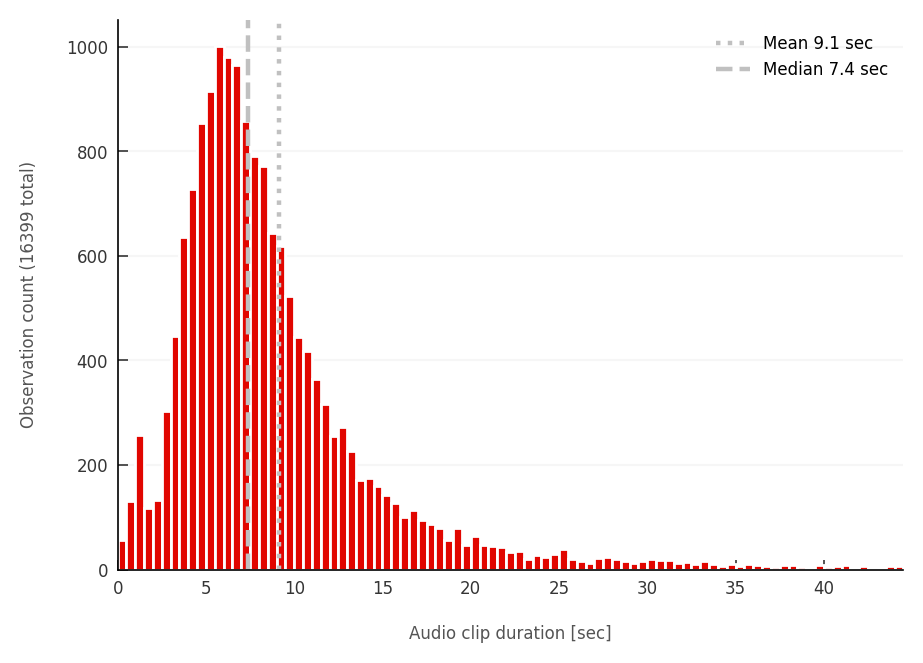

In [19]:
def get_clip_duration(file_path):
    try:
        return librosa.get_duration(path=file_path)
    except:
        return np.nan

if not "clip_duration" in radio_messages.columns:
    radio_messages["clip_duration"] = radio_messages["file_path"].apply(get_clip_duration)
    # radio_messages = radio_messages[radio_messages["clip_duration"] < 30]

plt.hist(
    radio_messages["clip_duration"],
    bins=np.arange(0, 45, 0.5),
    # density=True,
    color=COLORMAP.F1_red,
    edgecolor="white",
    linewidth=1,
)
plt.axvline(
    x=radio_messages["clip_duration"].mean(),
    color="silver",
    linestyle="dotted",
    label=f"Mean {radio_messages["clip_duration"].mean():.1f} sec",
)
plt.axvline(
    x=radio_messages["clip_duration"].median(),
    color="silver",
    linestyle="dashed",
    label=f"Median {radio_messages["clip_duration"].median():.1f} sec",
)
plt.legend(loc="upper right")
plt.xlabel("Audio clip duration [sec]")
# plt.ylabel("Probability density")
plt.ylabel(f"Observation count ({len(radio_messages)} total)")
plt.show()

In [ ]:
def download_audiofiles(file_path_todo_list):
    for _, radio_message in tqdm(list(file_path_todo_list), smoothing=0):
        if not Path(radio_message["file_path"]).exists():
            # print(f"""[INFO] saving {radio_message["file_path"]}""")
            with open(radio_message["file_path"], mode="wb") as file:
                file.write(requests.get(radio_message["recording_url"]).content)

download_audiofiles(
    file_path_todo_list=radio_messages[~radio_messages["file_path"].apply(Path).apply(Path.exists)][["recording_url", "file_path"]].iloc[::-1].iterrows(),
)

  0%|          | 0/16420 [00:00<?, ?it/s]

---

In [6]:
transcriptions = pd.read_csv("transcriptions.tsv", delimiter="\t").astype(dict(
    transcription_timestamp="datetime64[ns, UTC]",
))

radio_messages_transcribed = pd.merge(
    left=radio_messages.drop(columns=[
        "meeting_key",
        "session_key",
    ]),
    right=transcriptions,
    on="file_path",
    how="left",
).sort_values("transcription_timestamp").drop_duplicates(
    subset="file_path",
    keep="first",
)
radio_messages_transcribed = radio_messages_transcribed[~radio_messages_transcribed["transcription"].isna()]
radio_messages_transcribed["transcription_result"] = radio_messages_transcribed["transcription_result"].apply(lambda info_dict: ast.literal_eval(info_dict))

print(f"Found {len(radio_messages_transcribed)} transcribed radio messages")
radio_messages_transcribed.tail(3)

Found 3172 transcribed radio messages


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,transcription,transcription_result,pipeline
16388,81,2025-11-29 19:08:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Qualifying,OSCPIA01_81_20251129_220728.mp3,radio_messages/OSCPIA01_81_20251129_220728.mp3,14.520,2025-12-06 18:41:45.366569+00:00,"So did we get it? Yep, you got it. Just becau...","{'text': ' So did we get it? Yep, you got it. ...",model_variant
16407,81,2025-11-30 17:04:50.980000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Race,OSCPIA01_81_20251130_200422.mp3,radio_messages/OSCPIA01_81_20251130_200422.mp3,9.216,2025-12-06 18:42:00.183744+00:00,I think the only way of winning a three is if...,{'text': ' I think the only way of winning a t...,model_variant
16425,87,2025-12-05 09:48:03.594000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Practice 1,OLIBEA01_87_20251205_134751.mp3,radio_messages/OLIBEA01_87_20251205_134751.mp3,8.904,2025-12-06 18:42:14.379715+00:00,"Oh, I lost power. Okay, stand by. We have a l...","{'text': ' Oh, I lost power. Okay, stand by. W...",model_variant


In [ ]:
most_recent_label_export = pd.read_json(sorted(Path("label-studio/export").iterdir())[-1]).rename(columns=dict(
    transcription="human_transcription",
))
most_recent_label_export["file_path"] = most_recent_label_export["audio"].str.split("=").str[-1]

radio_messages_transcribed_with_reference = pd.merge(
    left=radio_messages_transcribed,
    right=most_recent_label_export[[
        "file_path",
        "human_transcription",
        "lead_time",
        "updated_at",
    ]].rename(columns=dict(updated_at="human_transcription_timestamp")),
    on="file_path",
    how="left",
).sort_values("human_transcription_timestamp")

example_list = []
for _, message in radio_messages_transcribed_with_reference.iterrows():
    preannotation = message["human_transcription"] if type(message["human_transcription"]) is str else "\n" + message["transcription"].lstrip()
    example_list.append(dict(
        data=dict(
            audio=f"""/data/local-files/?d={message["file_path"]}""",
            identifier=message["file_path"].split("/")[1],
        ),
        annotations=[dict(
            result=[dict(
                value=dict(
                    text=[message["human_transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
                origin="manual",
            )],
            # ground_truth=True,
        )] if type(message["human_transcription"]) is str else [],
        predictions=[dict(
            result=[dict(
                value=dict(
                    text=[message["transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
            )],
        )],
        total_annotations=int(type(message["human_transcription"]) is str),
    ))

with open("lalbe-studio/media/upload/annotation_tasks.json", mode="w") as file:
    json.dump(example_list, file)

radio_messages_transcribed_with_reference = radio_messages_transcribed_with_reference[~radio_messages_transcribed_with_reference["human_transcription"].isna()]

print(f"Found {len(radio_messages_transcribed_with_reference)} transcribed radio messages with reference")
radio_messages_transcribed_with_reference.sample(3)

Found 350 transcribed radio messages with reference


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,transcription,transcription_result,pipeline,human_transcription,lead_time,human_transcription_timestamp
4,23,2025-07-05 11:09:07.376000+00:00,https://livetiming.formula1.com/static/2025/20...,Silverstone,2025,Practice 3,ALEALB01_23_20250705_120850.mp3,radio_messages/ALEALB01_23_20250705_120850.mp3,3.864,2025-11-22 19:11:58.633196+00:00,What the f*** was that?,"{'text': ' What the f*** was that?', 'segments...",whisper_turbo,The **** was that?,NaN,2025-12-07 10:31:30.935849+00:00
1539,44,2024-05-25 10:41:33.718000+00:00,https://livetiming.formula1.com/static/2024/20...,Monaco,2024,Practice 3,LEWHAM01_44_20240525_124129.mp3,radio_messages/LEWHAM01_44_20240525_124129.mp3,4.608,2025-11-23 14:02:08.638859+00:00,"Yeah, probably, probably minus five on those,...","{'text': ' Yeah, probably, probably minus five...",whisper_turbo,"Yeah, probably, minus 5 on those. Minus 5.",NaN,2025-12-07 10:31:30.928172+00:00
678,4,2025-09-06 14:33:19.566000+00:00,https://livetiming.formula1.com/static/2025/20...,Monza,2025,Qualifying,LANNOR01_4_20250906_163307.mp3,radio_messages/LANNOR01_4_20250906_163307.mp3,4.080,2025-11-22 21:48:26.095899+00:00,We need to box this map.,"{'text': ' We need to box this map.', 'segment...",whisper_turbo,We need to box this lap.,8.437,2025-12-07 11:02:31.956690+00:00


In [ ]:
radio_messages_transcribed_with_reference.to_json(
    "data/transcribed_with_reference.json", 
    index=False, 
    orient="records",
)

In [9]:
def transcribe_radio_messages(model, model_identifier, file_path_todo_list, model_options=dict()):
    with open("transcriptions.tsv", mode="a") as file:
        for file_path in tqdm(file_path_todo_list, smoothing=0):
            try:
                transcription_result = model.transcribe(
                    str(file_path),
                    **model_options,
                )
            except Exception as exc:
                print(f"[ERROR] {file_path}: {repr(exc)}")
                transcription_result = dict(
                    text="",
                    reason=repr(exc),
                )
            file.write("\t".join((
                str(pd.Timestamp.now()),
                str(file_path),
                transcription_result["text"],
                str(transcription_result),
                model_identifier,
            )) + "\n")

if False:
    model_variant = "turbo"
    whisper_model = whisper.load_model(
        name=model_variant, 
        device="cuda" if torch.cuda.is_available() else "cpu", 
    )

    options = dict(
        language="en",
        verbose=False,
        fp16=False,
        # patience=2,
        # beam_size=5,
        temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
        compression_ratio_threshold=2.4,
        logprob_threshold=-1.0,
        no_speech_threshold=0.6,
        condition_on_previous_text=True, # maybe not?
        initial_prompt=None,
        carry_initial_prompt=False,
        word_timestamps=False,
    )

    todo_paths = radio_messages[
        ~radio_messages["file_path"].isin(radio_messages_transcribed["file_path"]) & 
        # radio_messages["file_path"].isin(most_recent_label_export["file_path"]) &
        (radio_messages["year"] == 2025)
    ]["file_path"].sample(frac=1)

    transcribe_radio_messages(
        model=whisper_model,
        model_identifier="model_variant",
        file_path_todo_list=todo_paths,
        model_options=options,
    )

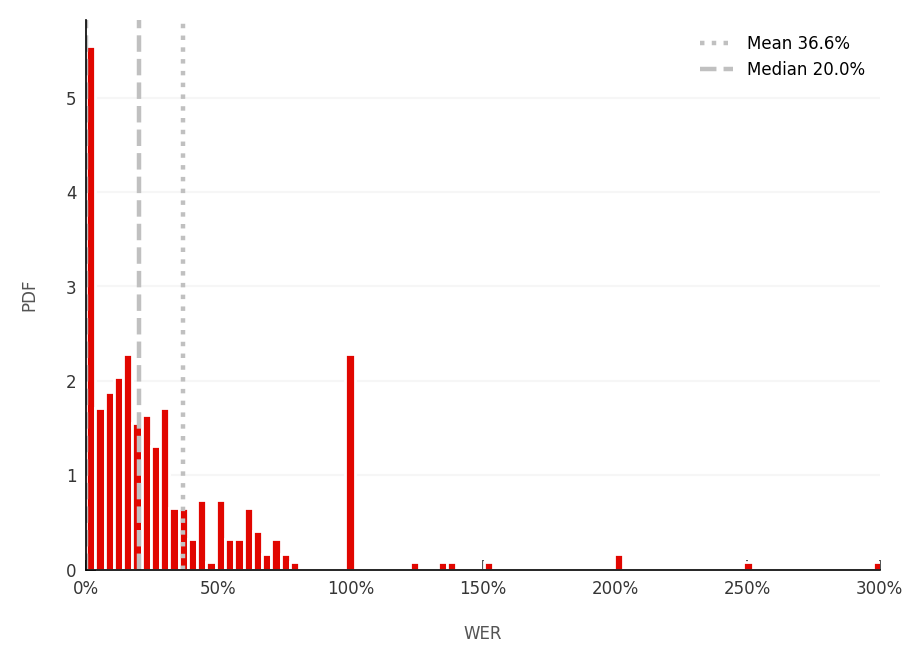

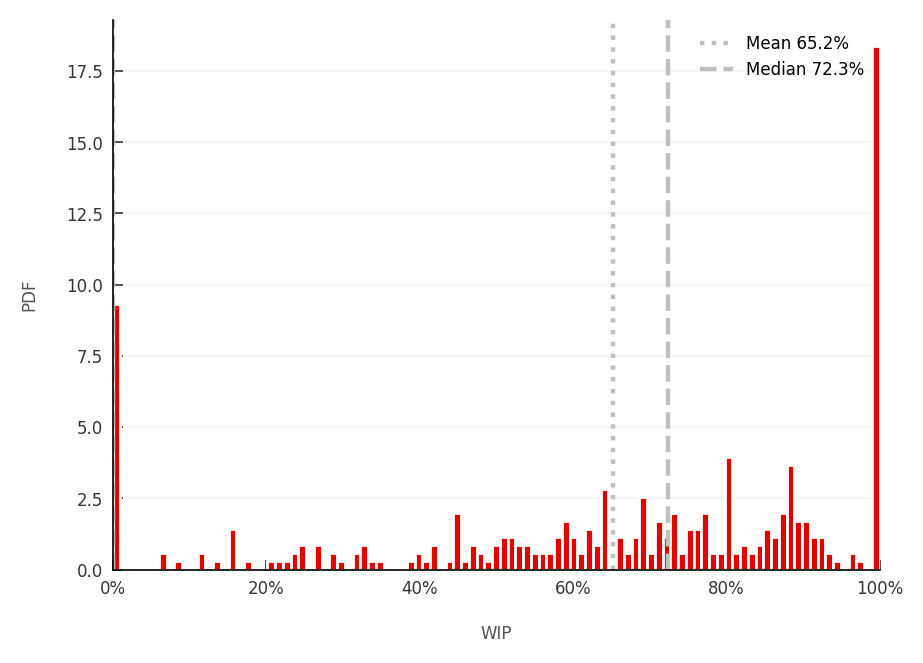

In [10]:
from whisper.normalizers import EnglishTextNormalizer
word_normalizer = EnglishTextNormalizer()

for metric, estimator in [
    ("wer", jiwer.wer),
    ("wip", jiwer.wip),
]:
    radio_messages_transcribed_with_reference[metric] = radio_messages_transcribed_with_reference.apply(lambda radio_message: estimator(
        word_normalizer(radio_message["transcription"]),
        word_normalizer(radio_message["human_transcription"]),
    ), axis=1)
    plt.hist(
        radio_messages_transcribed_with_reference[metric],
        bins=dict(
            wer=200,
            wip=np.linspace(0, 1, 100),
        )[metric],
        density=True,
        color=COLORMAP.F1_red,
        edgecolor="white",
        linewidth=1,
    )
    plt.axvline(
        color="silver",
        linestyle="dashed",
    )
    plt.axvline(
        x=radio_messages_transcribed_with_reference[metric].mean(),
        color="silver",
        linestyle="dotted",
        label=f"Mean {radio_messages_transcribed_with_reference[metric].mean():.1%}",
    )
    plt.axvline(
        x=radio_messages_transcribed_with_reference[metric].median(),
        color="silver",
        linestyle="dashed",
        label=f"Median {radio_messages_transcribed_with_reference[metric].median():.1%}",
    )
    plt.legend(loc="upper right")
    plt.xlabel(metric.upper())
    plt.ylabel("PDF")
    if metric == "wip":
        plt.xlim(0, 1)
    elif metric == "wer":
        plt.xlim(0, 3)
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.show()

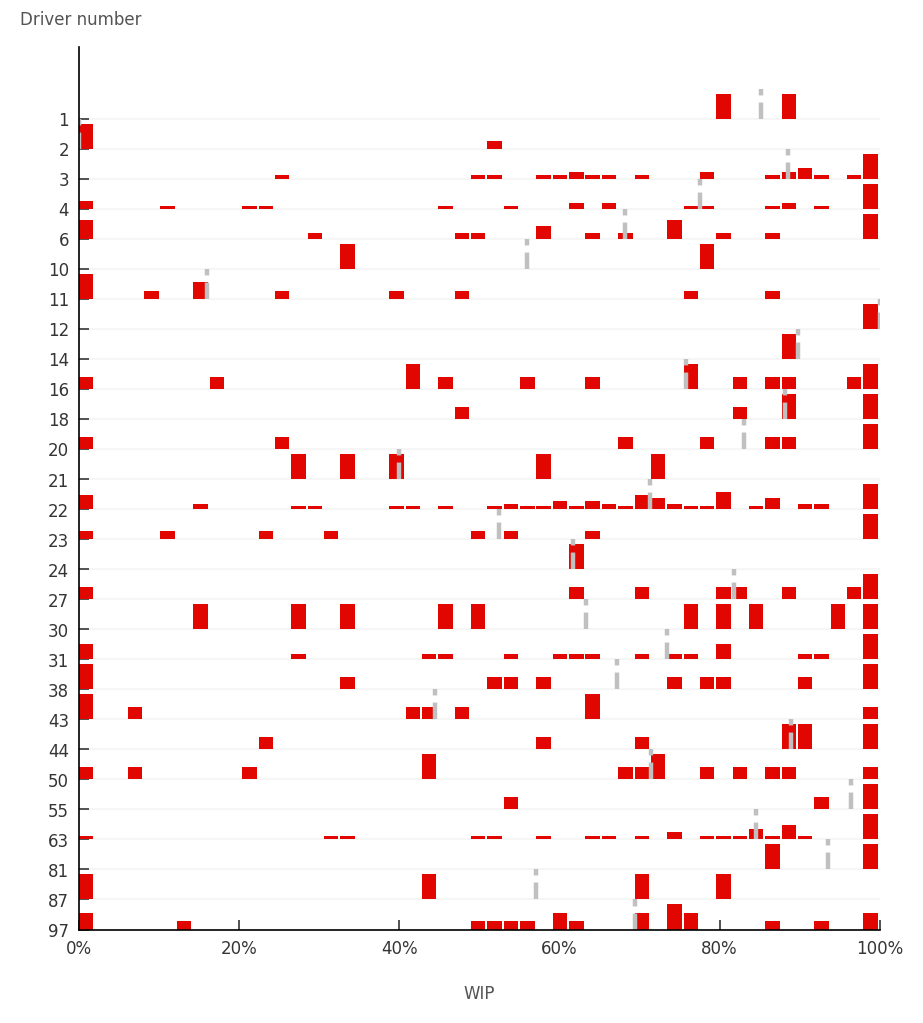

In [11]:
fig, ax = plt.subplots(figsize=(4.5, 5))

for row_idx, (driver_number, driver_data) in enumerate(radio_messages_transcribed_with_reference.groupby("driver_number")):
    hist, bin_edges = np.histogram(
        driver_data["wip"],
        bins=np.linspace(0, 1, 50),
    )
    plt.bar(
        x=bin_edges[:-1],
        height=np.array(hist) / max(hist) / 1.2,
        bottom=row_idx,
        width=0.018,
        color=COLORMAP.F1_red,
        align="edge",
    )
    plt.vlines(
        x=driver_data["wip"].median(),
        ymin=row_idx,
        ymax=row_idx + 1,
        color="silver",
        linestyle="dashed",
    )

plt.yticks(range(radio_messages_transcribed_with_reference["driver_number"].nunique()), radio_messages_transcribed_with_reference["driver_number"].sort_values(ascending=False).unique())
plt.ylabel("Driver number", y=1.02, rotation=0, ha="left")
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xlim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.xlabel("WIP")
plt.show()

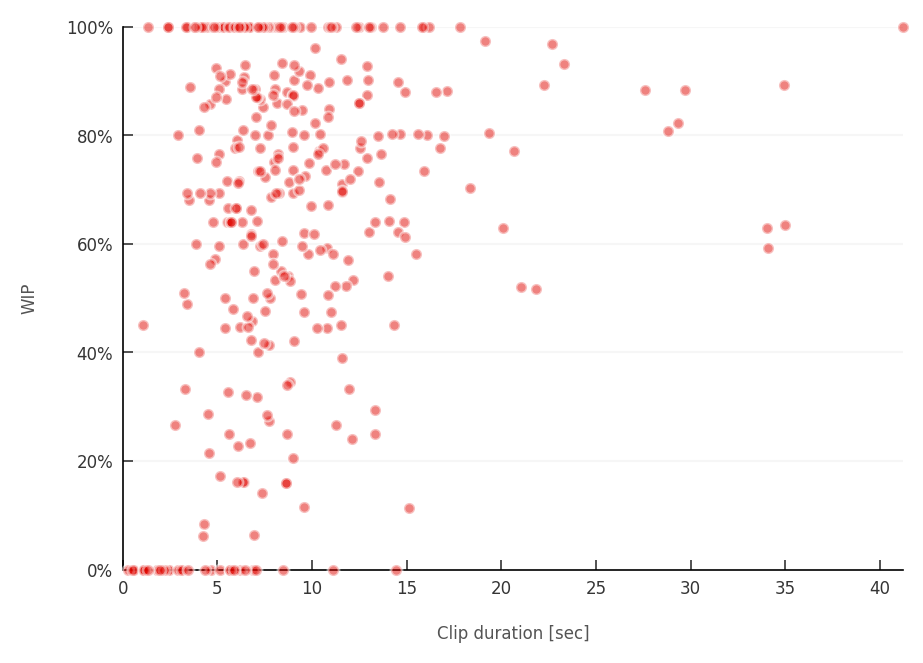

In [12]:
plt.scatter(
    radio_messages_transcribed_with_reference["clip_duration"],
    radio_messages_transcribed_with_reference["wip"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xlim(0)
plt.ylim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.ylabel("WIP")
plt.show()

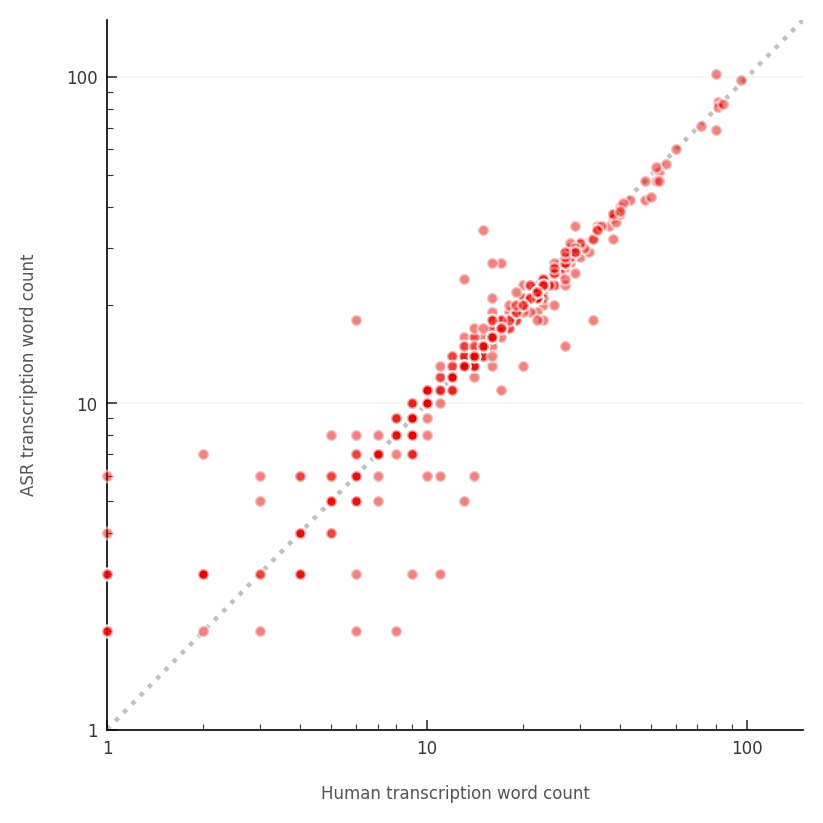

In [20]:
plt.figure(figsize=(4, 4))
plt.scatter(
    radio_messages_transcribed_with_reference["human_transcription"].str.split(" ").str.len(),
    radio_messages_transcribed_with_reference["transcription"].str.split(" ").str.len(),
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="silver",
    linestyle="dotted",
    zorder=-1,
)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(1, 150)
plt.ylim(1, 150)
plt.xlabel("Human transcription word count")
plt.ylabel("ASR transcription word count")
plt.show()

<!-- ln -s radio_messages/ /home/ucloud/.local/share/label-studio/radio_messages -->